In [2]:
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

/home/chris/miniconda3/envs/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
def show(tensor, num=25, wandbactivate=0, name=''):
    data = tensor.detach().cpu()
    grid = make_grid(data[:num], nrow=5).permute(1,2,0)\
    
    if wandbact==1:
        wandb.log({name: [wandb.Image(grid.numpy().clip(0,1))]})

    plt.imshow(grid.clip(0,1))
    plt.show()

## hyperparameters and general parameters
n_epochs = 10000
batch_size = 128
lr=1e-4
z_dim = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cur_step = 0
crit_cycles = 5
gen_losses = []
crit_losses = []
show_step = 35
save_step = 35
wandbact = 1

In [4]:
### optional
import wandb
wandb.login(key='fb2c29c63de8b8c11eaf54d371789ea89c2b4536')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wheogus98 (team-30). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/chris/.netrc


True

In [8]:
%%capture
experiment_name = wandb.util.generate_id()

myrun =wandb.init(
    project='wgan',
    group = experiment_name,
    config={
        'optimizer': 'adam',
        'model': 'wgan gp',
        'epoch': "1000",
        "batch_size": 128
    })
config = wandb.config
print(experiment_name)

In [13]:
#generator model

class Generator(nn.Module):
    def __init__(self, z_dim=64, d_dim=16):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0),
            nn.BatchNorm2d(d_dim * 32),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1),
            nn.BatchNorm2d(d_dim*16),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1),
            nn.BatchNorm2d(d_dim*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1),
            nn.BatchNorm2d(d_dim*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1),
            nn.BatchNorm2d(d_dim*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, noise):
        x=noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)
    
def gen_noise(num, z_dim, device='cuda'):
    return torch.randn(num, z_dim, device=device)


In [14]:
class Critic(nn.Module):
    def __init__(self, d_dim=16):
        super(Critic, self).__init__()
    
        self.crit = nn.Sequential(
            nn.Conv2d(3, d_dim, 4, 2, 1),
            nn.InstanceNorm2d(d_dim),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_dim, d_dim*2, 4, 2, 1),
            nn.InstanceNorm2d(d_dim*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1),
            nn.InstanceNorm2d(d_dim*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1),
            nn.InstanceNorm2d(d_dim*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1),
            nn.InstanceNorm2d(d_dim*16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_dim*16, 1, 4, 1, 0),
        )
    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)


In [15]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

# gen = gen.apply(init_weights)
# crit = crit.apply(init_weights)

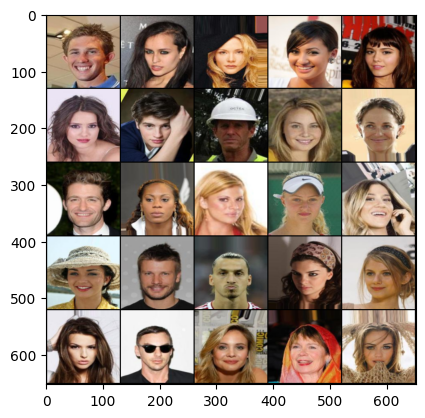

In [20]:
path = 'img_align_celeba/img_align_celeba/'

class Dataset(Dataset):
    def __init__(self, path, size=128, lim=10000):
        self.sizes=[size, size]
        items, labels = [], []
        for data in os.listdir(path)[:lim]:
            items.append(os.path.join(path, data))
            labels.append(data)
        self.items = items
        self.labels = labels
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        img = Image.open(self.items[idx]).convert('RGB')
        img = np.asarray(torchvision.transforms.Resize(self.sizes)(img))
        img = np.transpose(img, (2,0,1)).astype(np.float32, copy=False)
        img = torch.from_numpy(img).div(255)
        return img, self.labels[idx]

## dataloader
ds = Dataset(path, size=128, lim=10000)

dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

gen = Generator(z_dim=z_dim).to(device)
crit = Critic().to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5, 0.9))

gen = gen.apply(init_weights)
crit = crit.apply(init_weights)

if wandbact == 1:
    wandb.watch(gen, log_freq=100)
    wandb.watch(crit, log_freq=100)

x,y = next(iter(dataloader))
show(x)

In [22]:
## gradient penalty

def get_gp(real, fake, crit, alpha, gamma=10):
    mix_images = real * alpha + fake * (1-alpha)
    mix_scores = crit(mix_images)

    gradients = torch.autograd.grad(
        inputs=mix_images,
        outputs=mix_scores,
        grad_outputs=torch.ones_like(mix_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(len(gradients), -1)
    gradients_norm = gradients.norm(2, dim=1)
    return gamma * ((gradients_norm - 1)**2).mean()

In [24]:
## save and load checkpoints
root = "./checkpoints/"
def save_checkpoint(filename):
    torch.save({
        'epoch': n_epochs,
        'state_dict': gen.state_dict(),
        'optimizer': gen_opt.state_dict()
    }, f"{root}G={filename}.pkl")
    torch.save({
        'epoch': n_epochs,
        'state_dict': crit.state_dict(),
        'optimizer': crit_opt.state_dict()
    }, f"{root}C-{filename}.pkl")    
    print("Checkpoint saved")

def load_checkpoint(name):
    checkpoint = torch.load(f"{root}G-{name}.pkl")
    gen.load_state_dict(checkpoint['state_dict'])
    gen_opt.load_state_dict(checkpoint['optimizer'])

    checkpoint = torch.load(f"{root}C-{name}.pkl")
    crit.load_state_dict(checkpoint['state_dict'])
    crit_opt.load_state_dict(checkpoint['optimizer'])
    print("Checkpoint loaded")

In [25]:
save_checkpoint('init')

Checkpoint saved


In [26]:
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_bs = len(real)
        real = real.to(device)

        mean_crit_loss = 0
        for _ in range(crit_cycles):
            crit_opt.zero_grad()

            noise = gen_noise(cur_bs, z_dim, device=device)
            fake = gen(noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            alpha = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient_penalty = get_gp(real, fake.detach(), crit, alpha)
            crit_loss = -(torch.mean(crit_real_pred) - torch.mean(crit_fake_pred)) + gradient_penalty
            mean_crit_loss += crit_loss.item() / crit_cycles
            crit_loss.backward(retain_graph=True)
            crit_opt.step()
        
        crit_losses += [mean_crit_loss]
        gen_opt.zero_grad()
        noise = gen_noise(cur_bs, z_dim, device=device)
        fake = gen(noise)
        crit_fake_pred = crit(fake)

        gen_loss = -torch.mean(crit_fake_pred)
        gen_loss.backward()
        gen_opt.step()

        gen_losses += [gen_loss.item()]

        if wandbact == 1:
            wandb.log({
                "Epoch": epoch,
                "Step": cur_step,
                'gen_loss': gen_loss.item(),
                'crit_loss': mean_crit_loss
            })
        if cur_step % save_step == 0 and cur_step > 0:
            save_checkpoint("latest")
            
        if cur_step % show_step == 0 and cur_step > 0:
            show(fake, wandbactivate=1, name='fake')
            show(real, wandbactivate=1, name='real')
        
            gen_mean = sum(gen_losses[-show_step:]) / show_step
            crit_mean = sum(crit_losses[-show_step:]) / show_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, Critic loss: {crit_mean}")

            plt.plot(
                range(len(gen_losses)),
                torch.Tensor(gen_losses),
                label='gen loss'
            )
            plt.plot(
                range(len(crit_losses)),
                torch.Tensor(crit_losses),
                label='crit loss'
            )
            plt.ylim(-1000, 1000)
            plt.legend()
            plt.show()
        cur_step += 1


  0%|          | 0/79 [00:00<?, ?it/s]/home/chris/miniconda3/envs/env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 44%|████▍     | 35/79 [00:15<00:19,  2.21it/s]


AttributeError: 'int' object has no attribute 'log'